In [34]:
import torch
from lib.mnist_aug.mnist_augmenter import DataManager

In [47]:
# Converts labels (list of dict) to tensors (list of tensors of shape [n, 4])
def labels_to_tensor(labels, H, W):
    tensors = []
    for labels_ in labels:

        # For each bbox, we will have 4 numbers
        tensor = torch.zeros((len(labels_), 4), dtype=torch.float32)

        for i in range(len(labels_)):
            coordinates = [
                labels_[i]['cx'] / W,
                labels_[i]['cy'] / H,
                labels_[i]['width'] / W,
                labels_[i]['height'] / H,
            ]
            tensor[i] = torch.FloatTensor(coordinates)

        tensors.append(tensor.T)

    return tensors

In [ ]:

def get_shapes_from_sizes_ratios(sizes, ratios):
    sizes_ = torch.tensor(sizes, dtype=torch.float32).repeat_interleave(len(ratios))  # [1, 2, 3] => [1, 1, 2, 2, 3, 3]
    ratios_sqrt = torch.sqrt(torch.tensor(ratios, dtype=torch.float32)).repeat(len(sizes))

    w = sizes_ / ratios_sqrt
    h = sizes_ * ratios_sqrt

    return w, h


def get_anchor_centers(W, H):
    hs = torch.arange(1 / H / 2, 1, 1 / H).view((H, 1)).expand(
        (H, W))  # [0, 0.5, 1] => [(0,0,0), (0.5,0.5,0.5), (1,1,1)]
    ws = torch.arange(1 / W / 2, 1, 1 / W).view((1, W)).expand(
        (H, W))  # [0, 0.5, 1] => [(0,0.5,1), (0,0.5,1), (0,0.5,1)]

    return ws, hs  # 2 channels


# Generates a tensor of anchors
def generate_anchors(shape, sizes, ratios):
    k = len(sizes) * len(ratios)
    W, H = shape

    cx, cy = get_anchor_centers(W, H)
    w, h = get_shapes_from_sizes_ratios(sizes, ratios)

    cx = cx.view((H, W, 1)).expand((H, W, k)).flatten()
    cy = cy.view((H, W, 1)).expand((H, W, k)).flatten()

    w = w.view((1, k)).expand((H * W, k)).flatten()
    h = h.view((1, k)).expand((H * W, k)).flatten()

    return torch.stack((cx, cy, w, h))

In [43]:
# TODO: Pass in a batch of bboxes and single set of anchors.
def get_iou_map(boxes1, boxes2):
    n1 = boxes1.shape[1]
    n2 = boxes2.shape[1]

    boxes1 = boxes1.repeat_interleave(n2).reshape((4, n1 * n2))  # [1, 2] => [1, 1, 2, 2]
    boxes2 = boxes2.repeat((1, n1))  # [1, 2] => [1, 2, 1, 2]

    wb = boxes1[2]
    wa = boxes2[2]

    hb = boxes1[3]
    ha = boxes2[3]

    cxb = boxes1[0]
    cxa = boxes2[0]

    cyb = boxes1[1]
    cya = boxes2[1]

    wb_half = wb / 2
    hb_half = hb / 2

    x2b = cxb + wb_half
    x1b = cxb - wb_half

    y2b = cyb + hb_half
    y1b = cyb - hb_half

    wa_half = wa / 2
    ha_half = ha / 2

    x2a = cxa + wa_half
    x1a = cxa - wa_half

    y2a = cya + ha_half
    y1a = cya - ha_half

    x2 = torch.min(torch.stack((x2a, x2b)), 0)[0]
    x1 = torch.max(torch.stack((x1a, x1b)), 0)[0]

    y2 = torch.min(torch.stack((y2a, y2b)), 0)[0]
    y1 = torch.max(torch.stack((y1a, y1b)), 0)[0]

    w = x2 - x1
    h = y2 - y1

    w[w < 0] = 0
    h[h < 0] = 0

    intersection = w * h
    union = (wb * hb) + (wa * ha) - intersection
    iou = intersection / union

    return iou.view((n1, n2))

# iou = get_iou_map(y_[1], anchors_tensor)

KeyboardInterrupt: 

In [3]:
def sample_anchors(iou, b=256, positive_threshold=0.7, negative_threshold=0.3):
    n_bb, n_anchors = iou.shape
    iou[range(n_bb), iou.argmax(1)] = torch.ones(n_bb)  # For each of bb, max iou anchor will be 1

    positive_indices = torch.nonzero(iou > positive_threshold)
    bp = min(len(positive_indices), b / 2)
    positive_indices_ = torch.multinomial(torch.ones(len(positive_indices)), bp)  # Sampled
    positive_indices = positive_indices[positive_indices_]

    iou_n = torch.clone(iou)
    iou_n[iou_n > negative_threshold] = 0

    negative_indices = torch.nonzero(iou_n > 0)
    bn = min(len(negative_indices), b - bp)
    negative_indices_ = torch.multinomial(torch.ones(len(negative_indices)), bn)  # Sampled
    negative_indices = negative_indices[negative_indices_]

    return positive_indices, negative_indices

In [64]:
def get_diffs(bboxes, anchors, max_iou, argmax_iou) -> torch.Tensor:
    """
    Parameters
    ----------
    bboxes: Tensor of shape (4, n_bboxes)
    anchors: Tensor of shape (4, H*W*k)
    iou: Tensor of shape (n_bboxes, H*W*k)

    Returns
    -------
    diffs: A Tensor of shape (4*k, H, W)

    Steps:
    1. Find argmax IOUs
    2. Extract bbox coordinates of shape (4, H*W*k)
    3. Find diffs for each pair:
        i.
    """

    invalid_indices = torch.nonzero(max_iou == 0).view((-1))

    bboxes_max = bboxes[:, argmax_iou]

    tx = (bboxes_max[0] - anchors[0]) / anchors[2]
    ty = (bboxes_max[1] - anchors[1]) / anchors[3]

    tw = torch.log(bboxes_max[2] / anchors[2])
    th = torch.log(bboxes_max[3] / anchors[3])

    diffs = torch.stack((tx, ty, tw, th))  # Shape: (4, n_anchors)

    len_invalid = len(invalid_indices)
    diffs[:, invalid_indices] = torch.tensor([float('nan') for _ in range(4 * len_invalid)]).view((4, len_invalid))

    return diffs.view((4 * k, H, W))

In [65]:
def get_confidences(max_iou, confidence_threshold: int, shape) -> torch.Tensor:
    """
    Parameters
    ----------
    max_iou: Tensor of shape (H*W*k), this is the IOU with best bounding box for each anchor
    confidence_threshold: a real number between 0 to 1. All values >= this will be 1. Rest 0

    Returns
    -------
    confidences: Tensor of shape (k, H, W)
    """

    max_iou = max_iou.clone()
    max_iou[max_iou < confidence_threshold] = 0
    max_iou[max_iou >= confidence_threshold] = 1

    return max_iou.view(shape)


def get_labels(iou, bboxes, anchors, k, H, W, confidence_threshold):
    max_iou, argmax_iou = torch.max(iou, 0)

    confidences = get_confidences(max_iou, confidence_threshold, (k, H, W))
    diffs = get_diffs(bboxes, anchors, max_iou, argmax_iou)

    return torch.cat((confidences, diffs))


In [49]:

k = 9
W = 14
H = 14
B = 256
b = 2

y = [
    [
        {'id': 0,
         'class': 9,
         'class_one_hot': [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         'x1': 40,
         'y1': 26,
         'x2': 70,
         'y2': 56,
         'cx': 55.0,
         'cy': 41.0,
         'height': 30,
         'width': 30},
        {'id': 1,
         'class': 3,
         'class_one_hot': [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         'x1': 13,
         'y1': 78,
         'x2': 50,
         'y2': 112,
         'cx': 31.5,
         'cy': 95.0,
         'height': 34,
         'width': 37,
         'type': 'number'},
        {'id': 2,
         'class': 6,
         'class_one_hot': [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         'x1': 78,
         'y1': 35,
         'x2': 112,
         'y2': 70,
         'cx': 95.0,
         'cy': 52.5,
         'height': 35,
         'width': 34,
         'type': 'number'},
        {'id': 3,
         'class': 1,
         'class_one_hot': [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         'x1': 35,
         'y1': 46,
         'x2': 84,
         'y2': 95,
         'cx': 59.5,
         'cy': 70.5,
         'height': 49,
         'width': 49,
         'type': 'number'},
        {'id': 4,
         'class': 2,
         'class_one_hot': [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         'x1': 20,
         'y1': 55,
         'x2': 42,
         'y2': 77,
         'cx': 31.0,
         'cy': 66.0,
         'height': 22,
         'width': 22,
         'type': 'number'},
        {'id': 5,
         'class': 1,
         'class_one_hot': [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         'x1': 60,
         'y1': 11,
         'x2': 95,
         'y2': 46,
         'cx': 77.5,
         'cy': 28.5,
         'height': 35,
         'width': 35,
         'type': 'number'},
        {'id': 6,
         'class': 1,
         'class_one_hot': [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         'x1': 60,
         'y1': 79,
         'x2': 102,
         'y2': 112,
         'cx': 81.0,
         'cy': 95.5,
         'height': 33,
         'width': 42,
         'type': 'number'},
        {'id': 7,
         'class': 8,
         'class_one_hot': [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         'x1': 4,
         'y1': 14,
         'x2': 51,
         'y2': 61,
         'cx': 27.5,
         'cy': 37.5,
         'height': 47,
         'width': 47,
         'type': 'number'}],
    [
        {'id': 0,
         'class': 4,
         'class_one_hot': [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         'x1': 33,
         'y1': 28,
         'x2': 87,
         'y2': 82,
         'cx': 60.0,
         'cy': 55.0,
         'height': 54,
         'width': 54,
         'type': 'number'},
        {'id': 1,
         'class': 0,
         'class_one_hot': [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         'x1': 68,
         'y1': 69,
         'x2': 103,
         'y2': 104,
         'cx': 85.5,
         'cy': 86.5,
         'height': 35,
         'width': 35,
         'type': 'number'},
        {'id': 2,
         'class': 1,
         'class_one_hot': [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         'x1': 62,
         'y1': 0,
         'x2': 95,
         'y2': 33,
         'cx': 78.5,
         'cy': 16.5,
         'height': 33,
         'width': 33,
         'type': 'number'},
        {'id': 3,
         'class': 1,
         'class_one_hot': [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         'x1': 16,
         'y1': 88,
         'x2': 48,
         'y2': 112,
         'cx': 32.0,
         'cy': 100.0,
         'height': 24,
         'width': 32,
         'type': 'number'}]]

y_ = labels_to_tensor(y, 112, 112)

anchors_tensor = generate_anchors(shape=(W, H), sizes=(.15, .45, .75), ratios=(0.5, 1, 2))

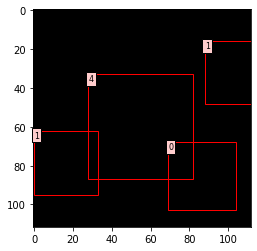

In [36]:
DataManager.plot_num(torch.ones((112, 112)), y[1])

In [50]:
iou = get_iou_map(y_[1], anchors_tensor)

In [68]:
positive, negative = sample_anchors(iou)

In [66]:
labels = get_labels(iou, y_[1], anchors_tensor, k, H, W, confidence_threshold=0.7)

In [67]:
#-=================================================

labels.shape

torch.Size([45, 14, 14])

In [71]:
positive.shape

torch.Size([5, 2])

In [72]:
negative.shape

torch.Size([251, 2])